# Analysis

## Join datasets together

In [15]:
import pandas as pd

# load data
df_cloud = pd.read_csv("../data/incidentsByDateCountry.csv")
df_strom = pd.read_csv("../storms_pre_processed.csv")
df_strom = df_strom.rename(columns={"Country": "country"})

df_strom["country"].replace(
    to_replace={"United Kingdom of Great Britain and Northern Ireland (the)": "United Kingdom",
                "Korea (the Republic of)": "South Korea",
                "United States of America (the)": "USA",
                "Taiwan (Province of China)": "Taiwan",
                "Netherlands (the)": "Netherlands",
                "Qatar": "Katar"
                }, inplace=True)

df_joined = pd.merge(df_cloud, df_strom, on=["date", "country"], how="inner")

#print(sorted(df_cloud["country"].drop_duplicates().dropna().to_list()))
#print(sorted(df_strom["country"].drop_duplicates().dropna().to_list()))
#print(sorted(df_joined["country"].drop_duplicates().dropna().to_list()))
cloud_set = set(df_cloud["country"].drop_duplicates().dropna().to_list())
joined_set = set(df_joined["country"].drop_duplicates().dropna().to_list())
not_intersection = joined_set ^ cloud_set
print(not_intersection)
print(df_cloud.shape)
print(df_strom.shape)
print(df_joined.shape)

['ASIA', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Europe', 'Finland', 'France', 'Germany', 'Global', 'Hong Kong', 'India', 'Indonesia', 'Israel', 'Italy', 'Japan', 'Katar', 'Netherlands', 'Poland', 'Singapore', 'South Korea', 'Spain', 'Switzerland', 'Taiwan', 'USA', 'United Kingdom']
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Bahamas (the)', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Canary Is', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros (the)', 'Congo (the Democratic Republic of the)', 'Congo (the)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic (the)', 'Côte d’Ivoire', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic (the)', 'Ecuad

In [ ]:
df_joined.to_csv("../data/full.csv")

# Variables Encoding

Read in data

In [46]:
import pandas as pd
df = pd.read_csv("../data/full.csv")

In [4]:
print(df.columns)

Index(['Unnamed: 0', 'Unnamed: 0_x', 'date', 'country', 'id', 'start', 'end',
       'severity', 'status', 'location', 'service_name',
       'number_affected_products', 'city', 'Unnamed: 0_y', 'Start Date',
       'End Date', 'Geo Locations', 'Disaster Type', 'Total Damages',
       'Total Deaths', 'Total Affected'],
      dtype='object')


## Dependent Variable

Boolean encoding where 1 if cloud outage severity is either high or medium.

In [70]:
# Take only outages with midium or high severity into consideration
df["dependent"] = 0
df.loc[df["severity"]== "low", "dependent"] = 1
df.loc[df["severity"] == "medium", "dependent"] = 2
df.loc[df["severity"] == "high", "dependent"] = 3
# Take all outages into account
df["dep_bool"] = 1
df.loc[df["id"].isnull(), "dep_bool"] = 0

# explore depdendent variable
print(df.shape[0])
print(df.loc[df["dep_bool"] == 1, "dep_bool"].count())
print(df.loc[df["dependent"] == 1, "dependent"].count())

10311
5574
4223


# Independent variable

Only look at specific weather events, take the monetary damage as the value

In [48]:
print(df["Disaster Type"].drop_duplicates().to_list())

[nan, 'Flood', 'Earthquake', 'Storm', 'Landslide', 'Volcanic activity', 'Wildfire', 'Extreme temperature ']


In [68]:
# factorize people affected by 1000
df['total_affected_factorized'] = df['Total Affected'].apply(lambda x: x*1000)
df['indep_damage_affected'] = df["Total Affected"]
df.loc[df['indep_damage_affected'].isnull(), 'indep_damage_affected'] = 0
# set to zero for the weather events we do not care about
df.loc[df["Disaster Type"] == "Extreme temperature", "indep_damag_affected"] = 0

# explore independent variable
numOfWeatherEvents = df.shape[0] - df["Disaster Type"].isna().sum()
print(numOfWeatherEvents)
print(df.loc[df["indep_damage_affected"] != 0, "indep_damage_affected"].count())

597
502


# Linear regression

Coefficients: 
 [1.88507922e-07]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.714
Date:                Wed, 20 Sep 2023   Prob (F-statistic):            0.00549
Time:                        14:04:48   Log-Likelihood:                -11288.
No. Observations:               10311   AIC:                         2.258e+04
Df Residuals:                   10309   BIC:                         2.259e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.68

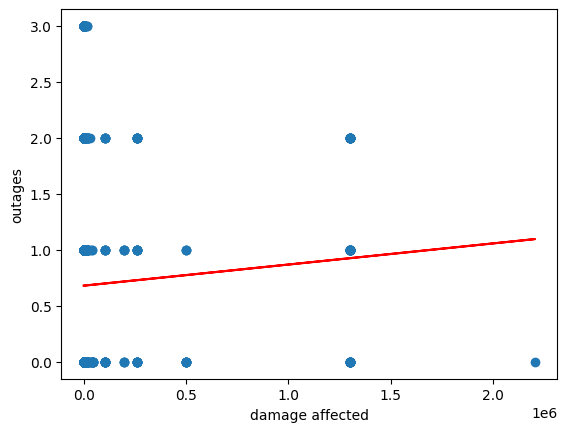

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

# plot the data
plt.scatter(df["indep_damage_affected"], df["dependent"], )
plt.xlabel("damage affected")
plt.ylabel("outages")
plt.savefig("outages_weather_scatter.png")


# model using linear regression
X = df["indep_damage_affected"].to_numpy().reshape(-1, 1)
Y = df["dependent"].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(X, Y)
print("Coefficients: \n", reg.coef_)

predicted_Y = reg.predict(X)

plt.plot(X, predicted_Y, color="red")


X = sm.add_constant(X) # add const to allow for constant offset of gradient
stats_results = sm.OLS(Y, X).fit()
print(stats_results.summary())